In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 15.1: Evidence approximation

## Objectives

+ To demonstrate one can estimate the hyper-parameters of Bayesian model using the evidence approximation.

## Example (Quadratic)

Let's generate some synthetic data from a quadratic function:

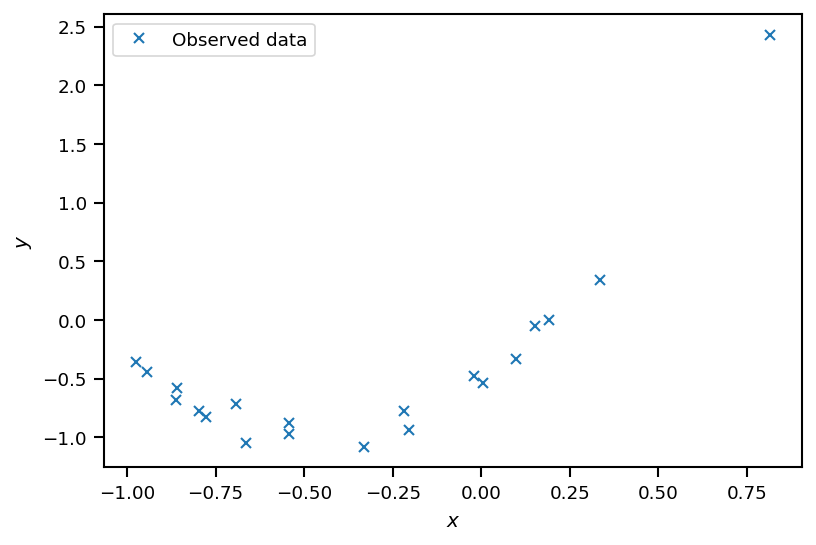

In [35]:
# How many observations we have
num_obs = 20
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [36]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

We are not going to implement the evidence approximation from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge).
Scikit-learn makes some default assumptions about the hyper-priors of $\sigma^2$ and $\alpha$.
You can change these assumptions if you wish (they assign a Gamma distribution to the inverse of these parameters).
However, these hyper-priors are generated under the assumption that the input-output pairs have been *normalized* before fitting.
To normalize the data, we subtract from the features and the outputs their empirical mean and we divide by their L2 norm.
Then you do regression between normalized features and outputs and you make sure that you correctly transform the results of your analysis back to the original ones.
Scikit-learn makes all this super easy as you just need to pass a single argument that says that you want to normalize.
Here is how you do it:

In [37]:
# Load the Bayesian linear regression class:
from sklearn.linear_model import BayesianRidge
# Select polynomial degree and get design matrix
degree = 3
# Build the design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# Train the model (notice the normalize=True argument)
# Also, the fit_intercept=False is required so that the model does not
# fit a constant offset (the intercept). This is included in our models
# as the first basis function phi_1(x) = 1.
model = BayesianRidge(normalize=True, fit_intercept=False).fit(Phi, y)

/Users/isaacbowser/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


Here is how to get the $\sigma$ that scikit-learn finds:

In [38]:
# Sklearn optimizes the precision of the noise which is the inverse of the variance.
# It calls it alpha_.
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.09


Here is how to get the $\alpha$ that scikit-learn finds:

In [39]:
# Sklearn optimizes alpha (the apriori precision of the weights), which
# it calls lambda_.
alpha = model.lambda_
print('alpha = {0:1.2f}'.format(alpha))

alpha = 0.46


The posterior mean of the weights (for the normalized features) is accessible here:

In [40]:
# The posterior mean of the weights is here (this is for the normalized data, however)
m_norm = model.coef_
print(m_norm)

[-0.50774173  2.05503965  2.0505931  -0.20164809]


The posterior covariance matrix of the weights (for the normalized features) is here:

In [41]:
# The posterior covariance matrix for the weights is here (also for the normalized data)
S_norm = model.sigma_
print(S_norm)

[[ 0.00094394  0.00079654 -0.00168576 -0.00144342]
 [ 0.00079654  0.01033262 -0.00102868 -0.01399782]
 [-0.00168576 -0.00102868  0.00786584  0.00661368]
 [-0.00144342 -0.01399782  0.00661368  0.02570619]]


Let's now make predictions separating aleatory and epistemic uncertainty just like we did before:

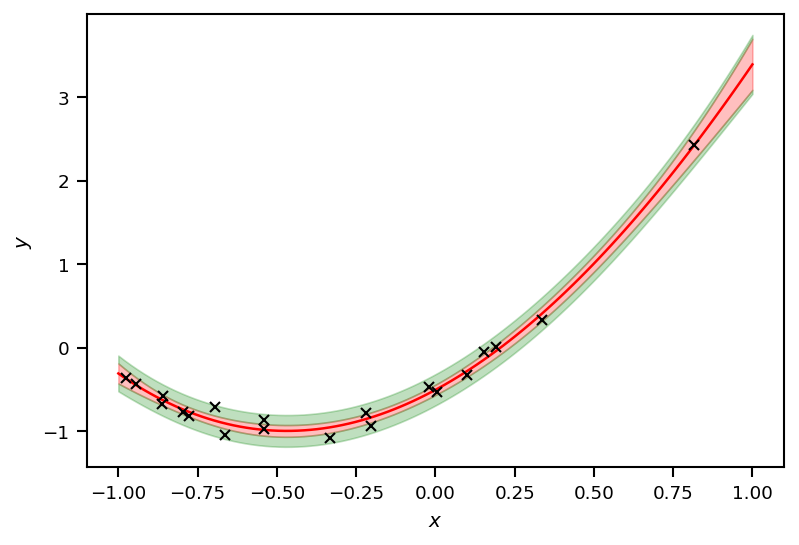

In [42]:
# Some points on which to evaluate the point predictive:
xx = np.linspace(-1, 1, 100)
# The features on these points (you don't have to normalize them, the ``model`` will
# do it internally)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
# Use the model to get the predictive mean and standard deviation:
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
# Separate the epistemic uncertainty
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Plot
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

What if you wanted to get the samples from the posterior?
This requires a bit of manual work because it is not implemented in scikit-learn.
We just need to make sure that we use the normalized features to make predictions.

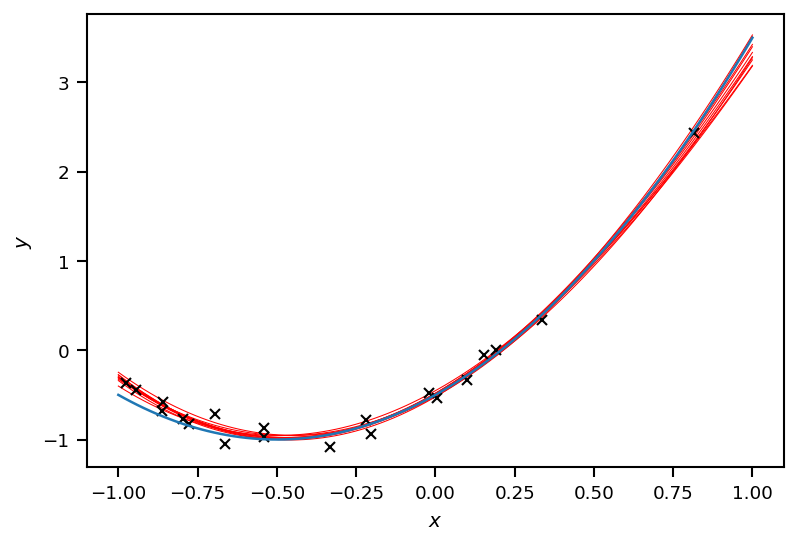

In [43]:
# First, let's get mean of the features as calculated inside the model
Phi_mean = model.X_offset_
# Then, let's get the scales of the features as caclulated inside the model
Phi_scale = model.X_scale_
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# These are the unscaled features:
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
# Here is how to scale them
Phi_xx_scaled = (Phi_xx - Phi_mean) / Phi_scale
# Note: We did not have to do this before because scikit-learn was already doing this
# for us

# Now let's put together the posterior of the weights
import scipy.stats as st
w_post = st.multivariate_normal(mean=m_norm, cov=S_norm)
# If you get an error because the covariance matrix is singular, add something small
# the diagonal. The covariance matrix is always positive definite (and non-singular)
# but it may have eigenvalues that are so close to zero that the numerical algorithms find
# them to be slightly negative. This is an artifact of the floating point precision.
# Comment the line above and uncomment the line below to fix the problem.
# w_post = st.multivariate_normal(mean=m_norm, cov=S_norm + 1e-6 * np.eye(S_norm.shape[0]))

# Let's take a plot some posterior samples
fig, ax = plt.subplots(dpi=150)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx_scaled, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions
+ Rerun with a smaller number of observations, say $N=5$. What happens to the epistemic uncertainty?
+ Rerun with a very small number of observations, say $N=2$. What happens then? (The step that samples from the posterior may not work as expected. Please look at the comment in the code to fix the problem.)
+ Rerun everything with a higher degree polynomial. Try $4$, $8$, and $16$.
Notice that the fit remains good in between but the way you extrapolate changes. Why?